<a href="https://colab.research.google.com/github/lmarieta/pollen/blob/main/pollen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import pandas as pd


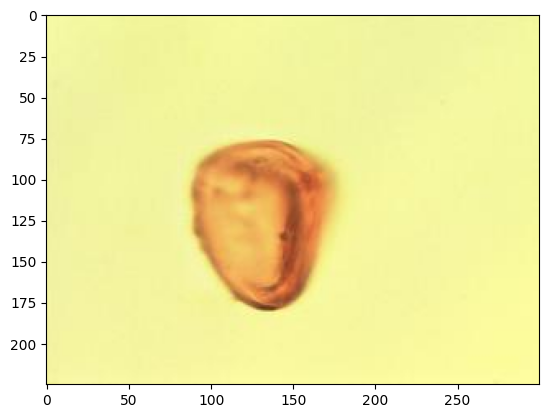

In [18]:
api_base_url = "https://api.globalpollenproject.org"
endpoint = "/api/v1/collection"
id_parameter_value = "a11174bb-2021-4a1a-b76c-4a19e3c3d233"
url_with_parameters = f"{api_base_url}{endpoint}?id={id_parameter_value}"


# Make the API request
try:
    response = requests.get(url_with_parameters)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Get the photo URL from the JSON response
        nested_structure = data.get("Slides")
        photo_url = nested_structure[0].get("Thumbnail") if nested_structure else None
        if photo_url:
            # Retrieve the image from the URL
            image_response = requests.get(photo_url)
            image_data = BytesIO(image_response.content)

            # Open and display the image using matplotlib
            img = Image.open(image_data)
            plt.imshow(img)
            plt.show()
        # Now you can work with the data
        #print(data)

    else:
        print(f"Error: {response.status_code}, {response.text}")

except requests.exceptions.RequestException as e:
    print(f"Request error: {e}")

In [49]:
id_list = ["607e1e8d-4b4a-42a5-ae92-89f09f7df560", "9bfaca14-7d2e-4d43-99d5-62227b5ed3e1",
           "56149a4d-13eb-4698-b244-0e06c6f5b9ae", "61ec04a1-ba7f-4942-9cb0-4873b7bf18b6",
           "3a8cd684-9423-4a99-af12-02c9fcd039ba", "9a612d33-2249-4722-8477-9ded722c3d9e"]
classes = ['Boraginaceae', 'Apiaceae', 'Malvaceae', 'Euphorbiaceae', 'Ericaceae', 'Caryophyllaceae']
df = pd.DataFrame(columns=['classes', 'index', 'image'])
data_list = []

,classes,index,image


In [55]:
for index, id in enumerate(id_list):
  id_parameter_value = id
  url_with_parameters = f"{api_base_url}{endpoint}?id={id_parameter_value}"

  # Make the API request
  try:
      response = requests.get(url_with_parameters)
      # Check if the request was successful (status code 200)
      if response.status_code == 200:
          # Parse the JSON response
          data = response.json()

          # Get the photo URL from the JSON response
          nested_structure = data.get("Slides")

          for img_index, image in enumerate(nested_structure):
            photo_url = image.get("Thumbnail") if nested_structure else None
            if photo_url:
                # Retrieve the image from the URL
                image_response = requests.get(photo_url)
                image_data = BytesIO(image_response.content)

                # Open and display the image using matplotlib
                img = Image.open(image_data)
                image_gray = img.convert('L')
                data_list.append({'classes': classes[index], 'index': img_index, 'image': image_gray})
                img.close()

      else:
          print(f"Error: {response.status_code}, {response.text}")

  except requests.exceptions.RequestException as e:
      print(f"Request error: {e}")

  df = pd.concat([pd.DataFrame([item]) for item in data_list], ignore_index=True)


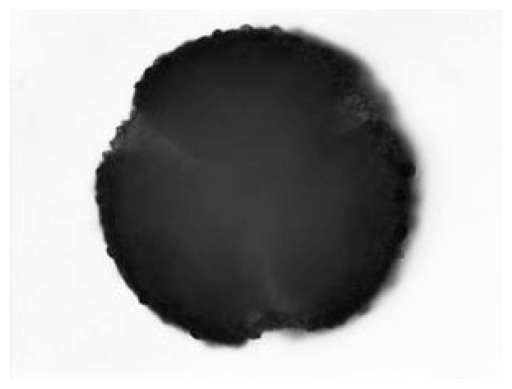

In [53]:
import numpy as np
# Display the first image in the DataFrame
first_image = df['image'].iloc[0]

# Convert Pillow Image to numpy array for displaying with matplotlib
image_array = np.array(first_image)

# Display the image using matplotlib
plt.imshow(image_array, cmap='gray')  # 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing 'classes', 'index', and 'image' columns

# Create a list to store the training and testing sets
train_sets = []
test_sets = []

# Unique classes in your DataFrame
unique_classes = df['classes'].unique()

# Loop through each unique class
for class_label in unique_classes:
    # Filter the DataFrame for the current class
    class_df = df[df['classes'] == class_label]

    # Split the data for the current class into train and test sets
    train_data, test_data = train_test_split(class_df, test_size=0.3, random_state=42)

    # Append the sets to the lists
    train_sets.append(train_data)
    test_sets.append(test_data)

# Concatenate the sets to get the final training and testing sets
train_set = pd.concat(train_sets, ignore_index=True)
test_set = pd.concat(test_sets, ignore_index=True)

# Display the shapes of the training and testing sets
print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)


Training set shape: (237, 3)
Testing set shape: (106, 3)


In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from PIL import Image
from PIL import ImageOps

# Assuming 'df' is your DataFrame with 'image' and 'encoded_classes' columns
# 'image' column should contain Pillow Image objects

# Convert Pillow Image objects to numpy arrays
df['image'] = df['image'].apply(lambda x: np.array(x))

# Resize images to a common size (e.g., 224x224)
target_size = (224, 224)
df['image'] = df['image'].apply(lambda x: np.array(Image.fromarray(x).resize(target_size)))

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert Pillow Image objects to numpy arrays and resize them to a consistent size
target_size = (224, 224)
X_train = np.array([np.array(ImageOps.fit(img, target_size)) for img in train_df['image']])
X_test = np.array([np.array(ImageOps.fit(img, target_size)) for img in test_df['image']])


# Normalize pixel values to a range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Convert class labels to categorical labels
y_train = tf.keras.utils.to_categorical(train_df['encoded_classes'])
y_test = tf.keras.utils.to_categorical(test_df['encoded_classes'])

# Model architecture (example using a simple CNN)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Adjust 'num_classes' based on your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


# Evaluate the model
test_loss, test_accuracy = model.evaluate(np.array(test_df['image'].tolist()), tf.keras.utils.to_categorical(test_df['encoded_classes']))
print(f'Test Accuracy: {test_accuracy}')



TypeError: 'int' object is not subscriptable